# Spurious Edge Detection: Pseudo-Self-Loop Filtering

**Problem**: Entity linker misattributes self-mentions to family members with shared surnames (e.g., "Darwin" → George Darwin instead of Charles Darwin). Standard self-loop filters miss these.

**Detection**: Combined filter requiring BOTH conditions:
1. Shared name components between source and target
2. Statistical outlier weight (z-score > threshold) relative to source node distribution

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src import filters

## 1. Load Data

In [24]:
INPUT_DATASET = '../data/out/SpotlightWeightSource_1210_0303.csv'

edges = pd.read_csv(INPUT_DATASET)
edges = edges.rename(columns={'weight': 'nij', 'source_wikidata_id': 'src', 'target_wikidata_id': 'tgt'})
edges = edges[edges['src'] != edges['tgt']]  # Remove self-loops
edges = edges[edges['nij'] > 0]  # Remove zero weights

print(f"Total edges: {len(edges):,}")
edges.head()

KeyboardInterrupt: 

In [ ]:
print("Weight Distribution:")
print(edges['nij'].describe())
print(f"95th percentile: {edges['nij'].quantile(0.95):.2f}")
print(f"99th percentile: {edges['nij'].quantile(0.99):.2f}")

Weight Distribution:
count    2.837458e+06
mean     1.645726e+00
std      2.560075e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.650000e+02
Name: nij, dtype: float64
95th percentile: 4.00
99th percentile: 10.00


## 2. Enrich Edges with English Titles

In [ ]:
from src.modules.duckdb_handler import DuckDBHandler

db = DuckDBHandler('/home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/graph_final.db')

# Drop existing title columns if present
title_cols = ['src_title', 'trg_title', 'src_title_x', 'trg_title_x', 'src_title_y', 'trg_title_y']
edges = edges.drop(columns=[col for col in title_cols if col in edges.columns])

# Get unique QIDs
qid_list = pd.unique(edges[['src', 'tgt']].values.ravel('K'))
qid_list = [str(qid) for qid in qid_list if pd.notna(qid)]

print(f"Retrieving titles for {len(qid_list):,} QIDs...")

# Retrieve and merge titles
titles_df = db.get_titles_for_qids_english(qid_list=qid_list, language_code='en')

edges = edges.merge(
    titles_df.rename(columns={'qid': 'src', 'title': 'src_title'}),
    on='src', how='left'
)
edges = edges.merge(
    titles_df.rename(columns={'qid': 'tgt', 'title': 'trg_title'}),
    on='tgt', how='left'
)

db.close()

print(f"Edges with both titles: {(edges['src_title'].notna() & edges['trg_title'].notna()).sum():,}")
display(edges[['src', 'src_title', 'tgt', 'trg_title', 'nij']].head(10))

Retrieving titles for 92,199 QIDs...
Edges with both titles: 2,836,180


,src,src_title,tgt,trg_title,nij
0,Q455209,"Anne Seymour, Duchess of Somerset",Q229279,Philippa of Hainault,1.0
1,Q129079,Paul Verhoeven,Q130531,Hieronymus Bosch,1.0
2,Q1279339,John Collins (mathematician),Q311814,Giovanni Alfonso Borelli,1.0
3,Q237642,Laodice III,Q359014,Mithridates II of Pontus,1.0
4,Q68409,Walter Peterhans,Q41508,Ludwig Mies van der Rohe,1.0
5,Q17612464,Jihadi John,Q17573849,Steven Sotloff,4.0
6,Q133903,Virgil van Dijk,Q219248,Marc Overmars,1.0
7,Q133903,Virgil van Dijk,Q745056,Kris Commons,2.0
8,Q133903,Virgil van Dijk,Q2896171,Benjamin Mendy,1.0
9,Q253458,Aristyllus,Q180671,Aratus,1.0


## 3. High-Weight Edges Exploration

In [ ]:
top_edges = edges.nlargest(50, 'nij')

print("Top 50 highest-weight edges:")
display_cols = ['src', 'src_title', 'tgt', 'trg_title', 'nij'] if 'src_title' in edges.columns else ['src', 'tgt', 'nij']
display(top_edges[display_cols])

Top 50 highest-weight edges:


,src,src_title,tgt,trg_title,nij
832605,Q150611,"Ferdinand I, Holy Roman Emperor",Q313426,"Ferdinand II, Archduke of Austria",965.0
2595881,Q314252,Gregory Bateson,Q297302,William Bateson,394.0
1696574,Q1541,Cicero,Q316054,Quintus Tullius Cicero,313.0
538082,Q191014,Isabel Perón,Q93330,Juan Perón,306.0
1706509,Q7721,Napoleon III,Q517,Napoleon,306.0
292827,Q186709,Nikolai Bukharin,Q1394,Vladimir Lenin,300.0
1482109,Q213122,Betty Ford,Q9582,Gerald Ford,292.0
998159,Q57177,Wolfram von Richthofen,Q4701,Manfred von Richthofen,291.0
944859,Q47152,Mary Shelley,Q93343,Percy Bysshe Shelley,290.0
2200005,Q529207,Ronaldo (Brazilian footballer),Q11571,Cristiano Ronaldo,275.0


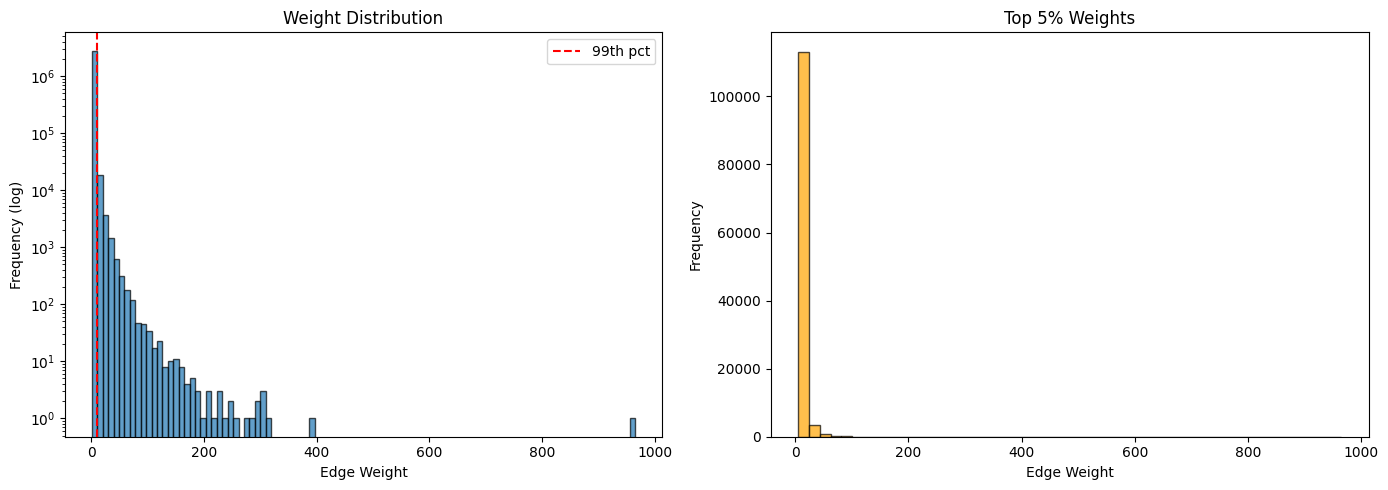

Edges with weight > 100: 135


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution
axes[0].hist(edges['nij'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_yscale('log')
axes[0].set_xlabel('Edge Weight')
axes[0].set_ylabel('Frequency (log)')
axes[0].set_title('Weight Distribution')
axes[0].axvline(edges['nij'].quantile(0.99), color='red', linestyle='--', label='99th pct')
axes[0].legend()

# Top 5% only
high_weights = edges[edges['nij'] > edges['nij'].quantile(0.95)]
axes[1].hist(high_weights['nij'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Edge Weight')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Top 5% Weights')

plt.tight_layout()
plt.show()

print(f"Edges with weight > 100: {len(edges[edges['nij'] > 100]):,}")

## 4. Absolute Threshold (Baseline)

Exclude edges with weight ≥ 100. Crude, context-unaware baseline.

In [ ]:
filter_weight_100 = filters.exclude_high_weight_edges(max_weight=100)
edges['keep_absolute'] = edges.apply(filter_weight_100, axis=1)

print(f"Excluded: {(~edges['keep_absolute']).sum():,} ({100*(~edges['keep_absolute']).sum()/len(edges):.2f}%)")

excluded = edges[~edges['keep_absolute']]
if len(excluded) > 0:
    print(f"\nTop 20 excluded edges:")
    sample_cols = ['src_title', 'trg_title', 'nij'] if 'src_title' in edges.columns else ['src', 'tgt', 'nij']
    display(excluded.nlargest(20, 'nij')[sample_cols])

Excluded: 142 (0.01%)

Top 20 excluded edges:


,src_title,trg_title,nij
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0
2595881,Gregory Bateson,William Bateson,394.0
1696574,Cicero,Quintus Tullius Cicero,313.0
538082,Isabel Perón,Juan Perón,306.0
1706509,Napoleon III,Napoleon,306.0
292827,Nikolai Bukharin,Vladimir Lenin,300.0
1482109,Betty Ford,Gerald Ford,292.0
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0
944859,Mary Shelley,Percy Bysshe Shelley,290.0
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0


## 5. Title Matching

Test if shared-name edges correlate with high weights.

In [ ]:
has_titles = 'src_title' in edges.columns and 'trg_title' in edges.columns

if has_titles:
    print(f"Source titles: {edges['src_title'].notna().sum():,} / {len(edges):,}")
    print(f"Target titles: {edges['trg_title'].notna().sum():,} / {len(edges):,}")
else:
    print("Title columns not found. Run enrichment first.")

Source titles: 2,836,526 / 2,837,458
Target titles: 2,837,031 / 2,837,458


In [ ]:
if has_titles:
    filter_shared_names = filters.exclude_edges_with_shared_names()
    edges['keep_title_filter'] = edges.apply(filter_shared_names, axis=1)
    edges['has_shared_name'] = ~edges['keep_title_filter']
    
    print(f"Edges with shared names: {edges['has_shared_name'].sum():,} ({100*edges['has_shared_name'].mean():.2f}%)")
    
    high_weight = edges[edges['nij'] > edges['nij'].quantile(0.95)]
    print(f"Among top 5% weights: {100*high_weight['has_shared_name'].mean():.1f}% have shared names")
    
    print("\nTop 10 shared-name edges with high weight:")
    examples = edges[edges['has_shared_name'] & (edges['nij'] > 50)].nlargest(10, 'nij')
    display(examples[['src_title', 'trg_title', 'nij']])
    
    print("\n20 random shared-name edges:")
    excluded = edges[~edges['keep_title_filter']]
    if len(excluded) > 0:
        display(excluded.sample(min(20, len(excluded)))[['src_title', 'trg_title', 'nij']])
else:
    print("Skipping - enrich data first")

Edges with shared names: 100,571 (3.54%)
Among top 5% weights: 8.8% have shared names

Top 10 shared-name edges with high weight:


,src_title,trg_title,nij
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0
2595881,Gregory Bateson,William Bateson,394.0
1696574,Cicero,Quintus Tullius Cicero,313.0
538082,Isabel Perón,Juan Perón,306.0
1706509,Napoleon III,Napoleon,306.0
1482109,Betty Ford,Gerald Ford,292.0
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0
944859,Mary Shelley,Percy Bysshe Shelley,290.0
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0



20 random shared-name edges:


,src_title,trg_title,nij
1435139,Hugh Despenser the Elder,Hugh Despenser the Younger,7.0
2203606,Frank Herbert,Brian Herbert,4.0
1961908,Nur Hassan Hussein,Saddam Hussein,2.0
1616039,Franz von Liszt,Franz Liszt,5.0
541611,Kim Jong-nam,Kim Il Sung,2.0
565066,Archduchess Gisela of Austria,Archduchess Auguste Ferdinande of Austria,1.0
1640545,Berenice (daughter of Herod Agrippa),Herod Agrippa,1.0
532855,Princess Augusta of Bavaria,Princess Augusta Wilhelmine of Hesse-Darmstadt,1.0
907483,"Christian, Landgrave of Hesse-Wanfried-Rheinfels","William II, Landgrave of Hesse-Wanfried-Rheinfels",2.0
1997104,"James Scott, 1st Duke of Monmouth","George Monck, 1st Duke of Albemarle",1.0


## 6. Relative Weight (Per-Node Outlier Detection)

Z-score based outlier detection. Edge weight compared to source node's distribution.

In [ ]:
node_stats = edges.groupby('src')['nij'].agg(['mean', 'std', 'count']).reset_index()
node_stats.columns = ['src', 'mean_weight', 'std_weight', 'edge_count']

edges = edges.merge(node_stats, on='src', how='left')
edges['z_score'] = (edges['nij'] - edges['mean_weight']) / edges['std_weight']
edges['z_score'] = edges['z_score'].fillna(0)

print("Per-node statistics:")
print(node_stats.describe())

Per-node statistics:
        mean_weight    std_weight    edge_count
count  90626.000000  87735.000000  90626.000000
mean       1.457562      1.008664     31.309536
std        0.664611      1.545581     42.595468
min        1.000000      0.000000      1.000000
25%        1.048780      0.267261      8.000000
50%        1.255089      0.581121     18.000000
75%        1.600000      1.194370     37.000000
max       16.500000     68.126501    775.000000


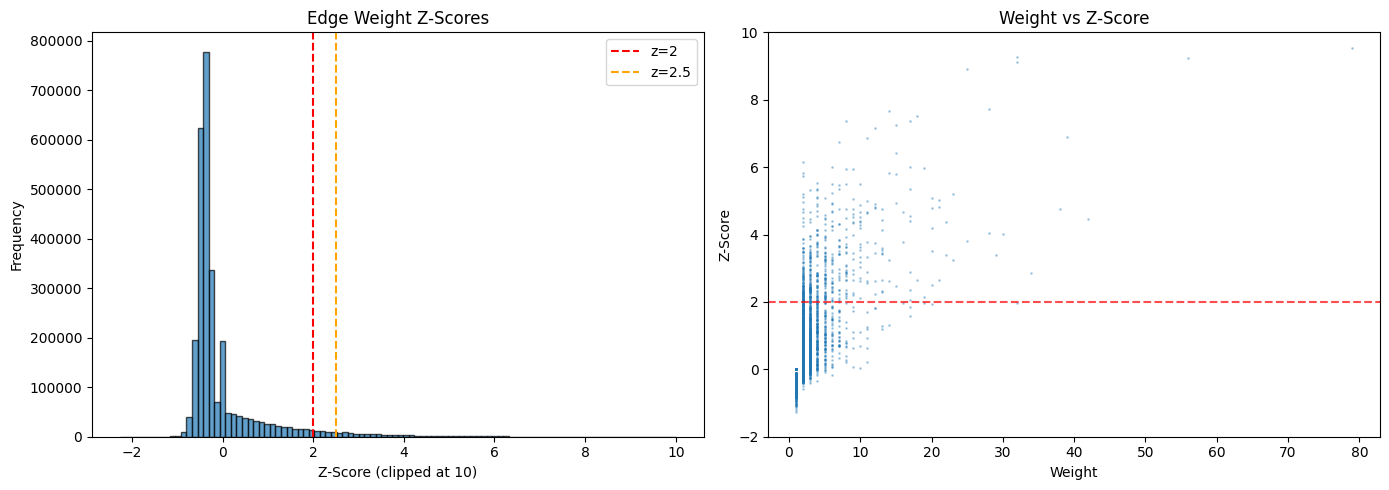

Edges with z > 2: 146,585 (5.17%)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Z-score histogram
axes[0].hist(edges['z_score'].clip(-5, 10), bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(2, color='red', linestyle='--', label='z=2')
axes[0].axvline(2.5, color='orange', linestyle='--', label='z=2.5')
axes[0].set_xlabel('Z-Score (clipped at 10)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Edge Weight Z-Scores')
axes[0].legend()

# Weight vs z-score
sample = edges.sample(min(10000, len(edges)))
axes[1].scatter(sample['nij'], sample['z_score'], alpha=0.3, s=1)
axes[1].axhline(2, color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('Z-Score')
axes[1].set_title('Weight vs Z-Score')
axes[1].set_ylim(-2, 10)

plt.tight_layout()
plt.show()

print(f"Edges with z > 2: {(edges['z_score'] > 2).sum():,} ({100*(edges['z_score'] > 2).mean():.2f}%)")

In [ ]:
edges_for_filter = edges[['src', 'tgt', 'nij']].rename(columns={'src': 'source', 'tgt': 'target'})

filter_relative = filters.exclude_edges_with_relative_high_weight(
    edges_df=edges_for_filter,
    std_threshold=2.0,
    min_edges_for_stats=5
)

edges['keep_relative'] = edges_for_filter.apply(filter_relative, axis=1)

print(f"Excluded: {(~edges['keep_relative']).sum():,} ({100*(~edges['keep_relative']).sum()/len(edges):.2f}%)")

excluded = edges[~edges['keep_relative']]
if len(excluded) > 0:
    print(f"\nTop 30 excluded by z-score:")
    sample_cols = ['src_title', 'trg_title', 'nij', 'z_score'] if 'src_title' in edges.columns else ['src', 'tgt', 'nij', 'z_score']
    display(excluded.nlargest(30, 'z_score')[sample_cols])

Excluded: 150,665 (5.31%)

Top 30 excluded by z-score:


,src_title,trg_title,nij,z_score
1748261,Pope Francis,Francis of Assisi,164.0,20.781768
2653801,Elton John,John Lennon,164.0,20.348882
337352,Venus Williams,Serena Williams,93.0,19.731038
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
893486,Johann Sebastian Bach,Carl Philipp Emanuel Bach,146.0,18.143089
684557,Cristiano Ronaldo,Ronaldo (Brazilian footballer),176.0,17.974417
79274,Catherine Deneuve,Catherine the Great,67.0,17.268309
742224,Novak Djokovic,Rafael Nadal,209.0,16.557621
1180801,John Wayne,John Ford,53.0,16.115626
1797465,Roger Federer,Rafael Nadal,151.0,15.964778


## 7. Combined Filter: Title Match AND Relative Weight

AND logic: exclude only if shared name AND z-score > threshold. Targets pseudo-self-loops.

In [ ]:
if has_titles:
    edges['keep_combined'] = edges['keep_title_filter'] | edges['keep_relative']
    edges['excluded_by_both'] = edges['has_shared_name'] & (~edges['keep_relative'])
    
    print("Filter Comparison:")
    print(f"Absolute (weight < 100): {(~edges['keep_absolute']).sum():,} excluded")
    print(f"Title matching only: {(~edges['keep_title_filter']).sum():,} excluded")
    print(f"Relative weight (z > 2): {(~edges['keep_relative']).sum():,} excluded")
    print(f"Combined (BOTH): {edges['excluded_by_both'].sum():,} excluded")
    
    pseudo_self_loops = edges[edges['excluded_by_both']]
    
    if len(pseudo_self_loops) > 0:
        print(f"\nPseudo-self-loops: {len(pseudo_self_loops):,}")
        print("\nTop 20 by weight:")
        display(pseudo_self_loops.nlargest(20, 'nij')[['src_title', 'trg_title', 'nij', 'z_score']])
        
        if len(pseudo_self_loops) > 20:
            print(f"\n20 random from remaining {len(pseudo_self_loops) - 20}:")
            remaining = pseudo_self_loops.nsmallest(len(pseudo_self_loops) - 20, 'nij')
            display(remaining.sample(min(20, len(remaining)))[['src_title', 'trg_title', 'nij', 'z_score']])
else:
    print("Cannot demo combined approach without titles")

Filter Comparison:
Absolute (weight < 100): 142 excluded
Title matching only: 100,571 excluded
Relative weight (z > 2): 150,665 excluded
Combined (BOTH): 9,550 excluded

Pseudo-self-loops: 9,550

Top 20 by weight:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119



20 random from remaining 9530:


,src_title,trg_title,nij,z_score
2145942,Prince Lorenz of Belgium,Princess Astrid of Belgium,6.0,3.521452
10161,Justin Kluivert,Patrick Kluivert,2.0,3.370408
1876550,Elvis Crespo,Elvis Presley,6.0,2.846050
1073645,Bohemond VII of Antioch,Bohemond IV of Antioch,8.0,4.666134
2422739,Ludwig Büchner,Georg Büchner,4.0,3.808473
2788417,Long John Baldry,Elton John,4.0,3.325462
2236936,Carlos Berlocq,Juan Carlos Ferrero,2.0,2.150109
2762250,Pope Innocent II,Antipope Anacletus II,18.0,5.198880
1509878,"Otto II, Holy Roman Emperor",Otto the Illustrious,15.0,3.860980
699568,Rishi Kapoor,Raj Kapoor,9.0,4.667793


Total edges: 2,837,458
Shared names only: 91,021
High z-score only: 141,115
BOTH (pseudo-self-loops): 9,550 ⚠️
Neither (clean): 2,595,772 ✓


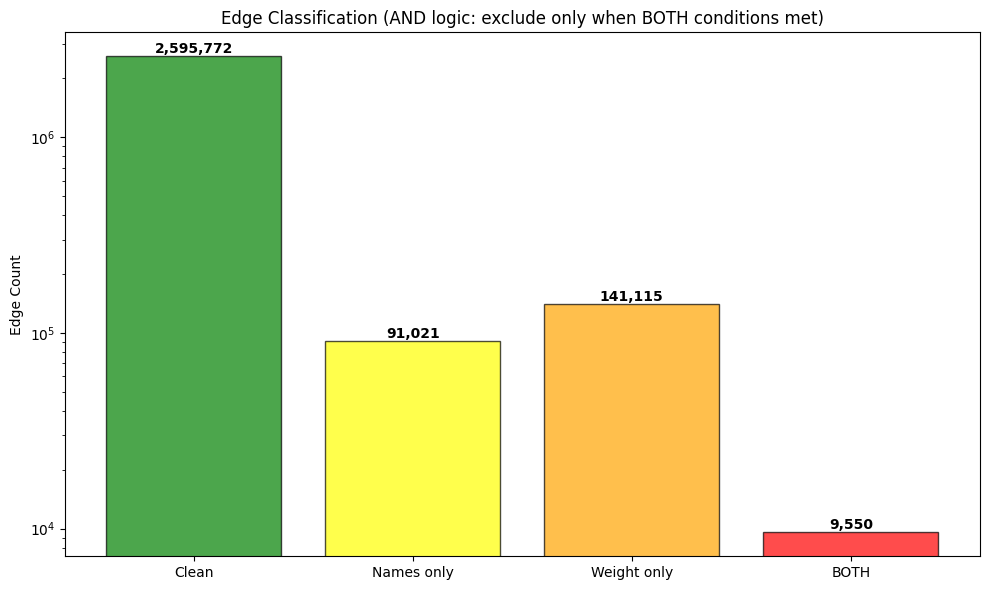

In [ ]:
if has_titles:
    only_title = edges['has_shared_name'] & edges['keep_relative']
    only_relative = (~edges['has_shared_name']) & (~edges['keep_relative'])
    both_criteria = edges['has_shared_name'] & (~edges['keep_relative'])
    neither = (~edges['has_shared_name']) & edges['keep_relative']
    
    print(f"Total edges: {len(edges):,}")
    print(f"Shared names only: {only_title.sum():,}")
    print(f"High z-score only: {only_relative.sum():,}")
    print(f"BOTH (pseudo-self-loops): {both_criteria.sum():,} ⚠️")
    print(f"Neither (clean): {neither.sum():,} ✓")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    categories = ['Clean', 'Names only', 'Weight only', 'BOTH']
    counts = [neither.sum(), only_title.sum(), only_relative.sum(), both_criteria.sum()]
    colors = ['green', 'yellow', 'orange', 'red']
    
    bars = ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Edge Count')
    ax.set_title('Edge Classification (AND logic: exclude only when BOTH conditions met)')
    ax.set_yscale('log')
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{count:,}',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Need titles for visualization")

## 8. Parameter Tuning

Adjust the z-score threshold to find the sweet spot for your data.

Threshold tuning:


,threshold,excluded_count,excluded_pct
0,1.5,211845,7.466014
1,2.0,150665,5.309858
2,2.5,104265,3.674592
3,3.0,72023,2.538293


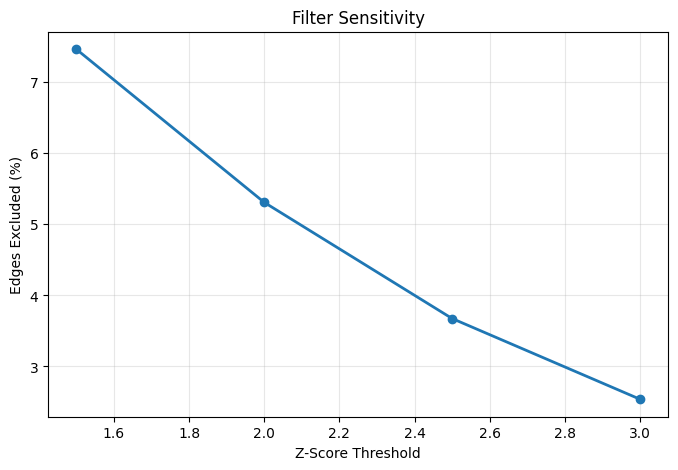

In [ ]:
thresholds = [1.5, 2.0, 2.5, 3.0]

results = []
for thresh in thresholds:
    edges_temp = edges[['src', 'tgt', 'nij']].rename(columns={'src': 'source', 'tgt': 'target'})
    
    filter_z = filters.exclude_edges_with_relative_high_weight(
        edges_df=edges_temp, std_threshold=thresh, min_edges_for_stats=5
    )
    
    keep = edges_temp.apply(filter_z, axis=1)
    excluded = (~keep).sum()
    
    results.append({
        'threshold': thresh,
        'excluded_count': excluded,
        'excluded_pct': 100 * excluded / len(edges)
    })

results_df = pd.DataFrame(results)
print("Threshold tuning:")
display(results_df)

plt.figure(figsize=(8, 5))
plt.plot(results_df['threshold'], results_df['excluded_pct'], marker='o', linewidth=2)
plt.xlabel('Z-Score Threshold')
plt.ylabel('Edges Excluded (%)')
plt.title('Filter Sensitivity')
plt.grid(True, alpha=0.3)
plt.show()

### Manual Verification

Examine combined filter results across thresholds.

In [ ]:
for thresh in thresholds:
    print(f"\n{'='*80}\nZ-SCORE THRESHOLD: {thresh}\n{'='*80}")
    
    edges_temp = edges[['src', 'tgt', 'nij']].rename(columns={'src': 'source', 'tgt': 'target'})
    filter_z = filters.exclude_edges_with_relative_high_weight(
        edges_df=edges_temp, std_threshold=thresh, min_edges_for_stats=5
    )
    keep_z = edges_temp.apply(filter_z, axis=1)
    
    if has_titles:
        excluded_combined = edges[edges['has_shared_name'] & (~keep_z)]
        
        print(f"Excluded: {len(excluded_combined):,} ({100*len(excluded_combined)/len(edges):.2f}%)")
        
        if len(excluded_combined) > 0:
            print("\nTop 10 by weight:")
            display(excluded_combined.nlargest(10, 'nij')[['src_title', 'trg_title', 'nij', 'z_score']])
            
            if len(excluded_combined) > 10:
                print(f"\n20 random samples:")
                n_samples = min(20, len(excluded_combined))
                display(excluded_combined.sample(n_samples)[['src_title', 'trg_title', 'nij', 'z_score']].sort_values('nij', ascending=False))
        else:
            print("✓ No pseudo-self-loops at this threshold")
    else:
        print("⚠️ Titles required")


Z-SCORE THRESHOLD: 1.5
Excluded: 12,542 (0.44%)

Top 10 by weight:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119



20 random samples:


,src_title,trg_title,nij,z_score
803052,Auguste Piccard,Bertrand Piccard,36.0,4.812891
2203596,Eleanor Marx,Karl Marx,26.0,1.828124
2424723,Yusuf II of Granada,Muhammad V of Granada,11.0,2.236933
2033365,Ronald Reagan,Nancy Reagan,8.0,2.548864
414903,Carlo Sforza,Francesco I Sforza,8.0,3.982146
2689349,Marcus Nonius Macrinus,Marcus Aurelius,7.0,3.082207
309771,Joseph Nasi,Gracia Mendes Nasi,6.0,2.774678
255857,Martha Wainwright,Rufus Wainwright,6.0,2.494299
655834,Ishaq ibn Ali,Ali ibn Yusuf,6.0,1.500000
1679943,George Adamson,Joy Adamson,6.0,2.012848



Z-SCORE THRESHOLD: 2.0
Excluded: 9,550 (0.34%)

Top 10 by weight:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119



20 random samples:


,src_title,trg_title,nij,z_score
525395,Emperor Suzong of Tang,Emperor Xuanzong of Tang,56.0,2.468112
1644792,Indira Gandhi,Mahatma Gandhi,35.0,3.285934
8766,Constance Wilde,Oscar Wilde,28.0,5.693765
48976,Renaud Capuçon,Gautier Capuçon,12.0,4.766838
639176,Seán Patrick O'Malley,Saint Patrick,11.0,4.862225
2823562,Anthemius (praetorian prefect),Anthemius,11.0,2.348001
2519757,Baudouin of Belgium,Leopold III of Belgium,10.0,4.454426
385760,Pedro I of Brazil,Pedro II of Brazil,10.0,2.651020
1359776,Theodore Komnenos Doukas,John III Doukas Vatatzes,8.0,1.988549
2691985,Constance I of Sicily,"Tancred, King of Sicily",7.0,2.212175



Z-SCORE THRESHOLD: 2.5
Excluded: 7,020 (0.25%)

Top 10 by weight:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119



20 random samples:


,src_title,trg_title,nij,z_score
1555383,Quintus Caecilius Metellus Pius,Quintus Sertorius,41.0,4.829017
351688,Clotilde,Clotilde of France,36.0,5.095694
2417105,Emma Darwin,Charles Darwin,33.0,3.831766
1622402,Henry VI of England,Richard III of England,23.0,5.384697
99330,Cate Campbell,Bronte Campbell,23.0,4.795936
1462813,Frederick the Great,Frederick William I of Prussia,19.0,6.224421
842886,Dante Gabriel Rossetti,Dante Alighieri,13.0,3.040675
1194590,Ashlee Simpson,Jessica Simpson,13.0,7.193406
1406371,Lambert Wilson,Georges Wilson,8.0,6.507232
1279467,Mithridates II of Pontus,Seleucus II Callinicus,8.0,4.606663



Z-SCORE THRESHOLD: 3.0
Excluded: 5,157 (0.18%)

Top 10 by weight:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119



20 random samples:


,src_title,trg_title,nij,z_score
2292172,Hannah Chaplin,Charlie Chaplin,28.0,3.589118
1303902,Princess Victoria Louise of Prussia,Queen Victoria,27.0,6.125174
2239413,Queen Anne-Marie of Greece,Constantine II of Greece,25.0,7.254761
2730780,Ptolemy III Euergetes,Ptolemy II Philadelphus,22.0,6.734220
776205,Diego de Covarrubias y Leyva,Alonso de Covarrubias,18.0,4.855232
1469471,Mario Cuomo,Andrew Cuomo,16.0,5.937356
2384770,Henry II of Cyprus,Hugh IV of Cyprus,14.0,4.780914
2822177,Marino Sanuto the Elder,Marino Sanuto the Younger,14.0,3.942657
2310737,Aleksey Nikolayevich Tolstoy,Leo Tolstoy,14.0,4.197365
597755,Friedrich Schleiermacher,Friedrich Schlegel,13.0,4.339837


## 10. Export Filtered Dataset

Set threshold and export cleaned data.

In [ ]:
CHOSEN_THRESHOLD = 2.0  # TODO: Update based on verification above

print(f"Selected threshold: {CHOSEN_THRESHOLD}")

if has_titles:
    edges_temp = edges[['src', 'tgt', 'nij']].rename(columns={'src': 'source', 'tgt': 'target'})
    filter_z = filters.exclude_edges_with_relative_high_weight(
        edges_df=edges_temp, std_threshold=CHOSEN_THRESHOLD, min_edges_for_stats=5
    )
    keep_z = edges_temp.apply(filter_z, axis=1)
    
    edges['keep_final'] = edges['keep_title_filter'] | keep_z
    pseudo_self_loops = edges[~edges['keep_final']]
    
    print(f"\nOriginal edges: {len(edges):,}")
    print(f"Excluded (pseudo-self-loops): {len(pseudo_self_loops):,} ({100*len(pseudo_self_loops)/len(edges):.2f}%)")
    print(f"Retained: {edges['keep_final'].sum():,} ({100*edges['keep_final'].mean():.2f}%)")
    
    edges_filtered = edges[edges['keep_final']].copy()
    
    if len(pseudo_self_loops) > 0:
        print("\nTop 10 excluded:")
        display(pseudo_self_loops.nlargest(10, 'nij')[['src_title', 'trg_title', 'nij', 'z_score']])
else:
    print("⚠️ Title enrichment required")
    edges_filtered = edges.copy()

Selected threshold: 2.0

Original edges: 2,837,458
Excluded (pseudo-self-loops): 9,550 (0.34%)
Retained: 2,827,908 (99.66%)

Top 10 excluded:


,src_title,trg_title,nij,z_score
832605,"Ferdinand I, Holy Roman Emperor","Ferdinand II, Archduke of Austria",965.0,14.054261
2595881,Gregory Bateson,William Bateson,394.0,7.345226
1696574,Cicero,Quintus Tullius Cicero,313.0,18.498220
538082,Isabel Perón,Juan Perón,306.0,6.839507
1706509,Napoleon III,Napoleon,306.0,15.907190
1482109,Betty Ford,Gerald Ford,292.0,8.401733
998159,Wolfram von Richthofen,Manfred von Richthofen,291.0,6.124021
944859,Mary Shelley,Percy Bysshe Shelley,290.0,10.324264
2200005,Ronaldo (Brazilian footballer),Cristiano Ronaldo,275.0,14.656489
530988,Otto the Great,"Otto II, Holy Roman Emperor",260.0,11.629119


In [ ]:
import os

original_filename = os.path.basename(INPUT_DATASET)
original_name_without_ext = os.path.splitext(original_filename)[0]

# Prepare output
output_df = edges_filtered[['src', 'tgt', 'nij', 'language_code']].copy()
output_df = output_df.rename(columns={
    'src': 'source_wikidata_id',
    'tgt': 'target_wikidata_id',
    'nij': 'weight'
})
output_df = output_df.sort_values('weight', ascending=False)

output_file = f"../data/out/{original_name_without_ext}_filtered_z{CHOSEN_THRESHOLD}.csv"
output_df.to_csv(output_file, index=False)

print(f"{'='*80}\nDATASET EXPORTED\n{'='*80}")
print(f"Output: {os.path.basename(output_file)}")
print(f"Rows: {len(output_df):,}")
print(f"\nFilename format: {original_name_without_ext}_filtered_z{CHOSEN_THRESHOLD}.csv")
print("✓ Ready for bias analysis\n")

display(output_df.head(10))

DATASET EXPORTED
Output: SpotlightWeightSource_1210_0303_filtered_z2.0.csv
Rows: 2,827,908

Filename format: SpotlightWeightSource_1210_0303_filtered_z2.0.csv
✓ Ready for bias analysis



,source_wikidata_id,target_wikidata_id,weight,language_code
292827,Q186709,Q1394,300.0,fr
811208,Q12897,Q336916,243.0,en
742224,Q5812,Q10132,209.0,fr
2085157,Q169814,Q355033,204.0,fr
1459257,Q469701,Q1405,181.0,de
2200152,Q51673,Q1405,178.0,en
2509386,Q41749,Q352,167.0,es
1937893,Q10132,Q1426,166.0,es
1431161,Q5812,Q10132,165.0,es
2490688,Q310739,Q8409,159.0,en


## 11. Summary

The combined method using shared names AND z-score > threshold appears most reliable, though minimally effective. This system successfully detects many pseudo-self-loops with unusually high weights, but fails to recognize incorrect links. This limitation cannot be resolved without improving the Entity Linking step.